# Import libraries and load data 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_columns',None)

In [2]:
data = pd.read_csv('/NFS_SQUAD_HISTO/OCI_DATA/02_intermediate/preprocessed_oss_counter_all_v3_new.csv',delimiter ='|')
data = data.sort_values(by=['week_period'])
data = data.drop('Unnamed: 0', axis =1)

# Data Analyse
## Sampling

In [3]:
data.sample(n=5)

,index,cell_name,date,cell_band,cell_tech,cell_sector,year,week,week_period,site_id,total_data_traffic_dl_gb,total_voice_traffic_kerlands,average_throughput_user_dl_kbps,average_throughput_user_ul_kbps,cell_occupation_dl_percentage,average_number_of_users_dl,average_number_of_users_ul,cell_occupation_ul_percentage,total_data_traffic_ul_gb,lost_traffic_kerlands,traffic_loss_rate,average_number_of_users_in_queue
2908716,1759709,OCI2260_KOUAMEADJI_U21-12,2020-03-16,U21,3G,1,2020,12,202012,OCI2260,15.570,82.82,2856.76,110.00,84.43,NaN,NaN,NaN,0.0,0.000000,0.000000,1.0
758500,758500,OCI1924_SAGBE_TERMINUS_U21-12,2021-03-01,U21,3G,1,2021,9,202109,OCI1924,20.230,59.86,3574.27,284.00,91.79,NaN,NaN,NaN,0.0,0.000000,0.000000,1.0
1335779,160568,OCI0190_BIA_ND_G9-1,2021-01-11,G9,2G,1,2021,2,202102,OCI0190,0.080,102.40,15.83,21.56,5.27,NaN,NaN,NaN,0.0,0.000000,0.000000,NaN
2526357,1370947,OCI1787_ABOUSSOUAN_U21-21,2020-10-19,U21,3G,2,2020,43,202043,OCI1787,7.920,149.19,2285.09,237.00,71.91,NaN,NaN,NaN,0.0,0.000000,0.000000,1.0
2678146,1525295,OCI1979_GBINI_G18-1,2020-02-24,G18,2G,1,2020,9,202009,OCI1979,0.815,612.07,37.72,17.63,19.17,NaN,NaN,NaN,0.0,6.182525,0.010101,NaN


## Number of records per date

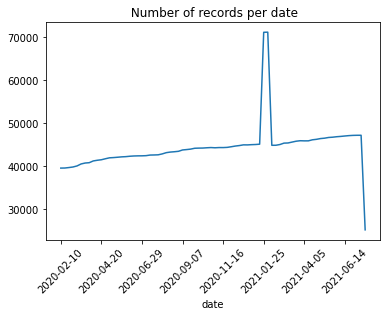

In [31]:
data.groupby('date').size().plot()
plt.xticks(rotation=45)
plt.title(' Number of records per date')
plt.show()

we may see that we have a suspicious peak around the 4th and 5th week of 2021. Let's zoom in

### Zoom in

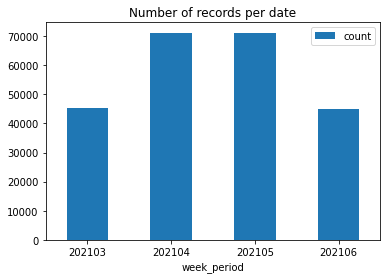

In [32]:
critical_periods_counts =[(202103 + a, len(data[data['week_period'] == 202103+a])) for a in range (4)]
critical = pd.DataFrame(critical_periods_counts, columns=['week_period','count'])
critical.plot(kind='bar',x='week_period')
plt.xticks(rotation=0)
plt.title('Number of records per date')
plt.show()

We passed from nearly 45000 record in 202103 to 70000 in 202104 and 202105 (+35%). Just after that number of records became normal again.
In the following parts of the notebook we will try to see whether this raise is due to :
- More sites 
- More cells

### Number of sites in and aroud the critical period 

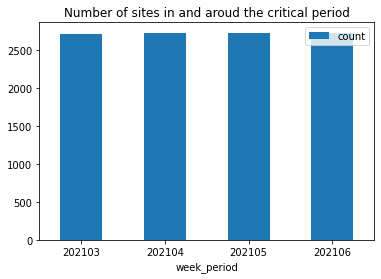

In [30]:
critical_periods_sites =[(202103 + a, len(data[data['week_period'] == 202103+a]['site_id'].unique()))
                          for a in range (4)]
critical = pd.DataFrame(critical_periods_sites, columns=['week_period','count'])
critical.plot(kind='bar',x='week_period')
plt.xticks(rotation=0)
plt.title('Number of sites in and aroud the critical period')
plt.show()

### Number of cells in and aroud the critical period 

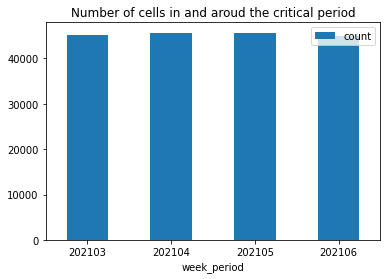

In [29]:
critical_periods_cells =[(202103 + a, len(data[data['week_period'] == 202103+a]['cell_name'].unique()))
                          for a in range (4)]
critical = pd.DataFrame(critical_periods_cells, columns=['week_period','count'])
critical.plot(kind='bar',x='week_period')
plt.xticks(rotation=0)
plt.title('Number of cells in and aroud the critical period')
plt.show()

### Result : 
The number of cells and the number of sites have stayed the same in and around the critical period. we can make no conclusion. 
A good way to procede is to see the distibution of technlogies (since every techno came from a separate data file).
### Technologies distribution in the critical period 


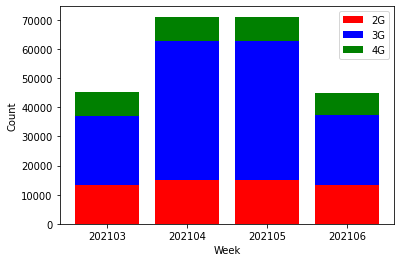

In [26]:
critical_periods_techs = data[(data['week_period'] >= 202103) & (data['week_period'] <= 202106)]\
.groupby(['week_period','cell_tech']).size()
labels = ['202103', '202104', '202105', '202106']
two_g = []
three_g = []
four_g = []
for label in labels : 
    week = critical_periods_techs[int(label)]
    two_g += [week['2G']]
    three_g += [week['3G']]
    four_g += [week['4G']]

plt.bar(labels,two_g,color='r')
plt.bar(labels,three_g, bottom=two_g, color='b')
plt.bar(labels,four_g, bottom=np.array(two_g)+np.array(three_g), color='g')
plt.xlabel('Week')
plt.ylabel('Count')
plt.legend(["2G",'3G','4G'])
plt.show()
    

the 35% raise observed earlier is mainly due to 3G files. we will check for duplicates 
### Duplicated records in the 3G file in the critical period (Using date and cell_name as record identifier)

In [5]:
data_3g = data[(data['week_period'] >= 202103) & (data['week_period'] <= 202106) & (data['cell_tech'] == '3G')]
duplicated = data_3g[data_3g.duplicated(subset=['cell_name','date'],keep=False)]\
            .sort_values(by=['date','cell_name'])
duplicated

,index,cell_name,date,cell_band,cell_tech,cell_sector,year,week,week_period,site_id,total_data_traffic_dl_gb,total_voice_traffic_kerlands,average_throughput_user_dl_kbps,average_throughput_user_ul_kbps,cell_occupation_dl_percentage,average_number_of_users_dl,average_number_of_users_ul,cell_occupation_ul_percentage,total_data_traffic_ul_gb,lost_traffic_kerlands,traffic_loss_rate,average_number_of_users_in_queue
300,300,OCI0001_ABADJIN_U21-11,2021-01-25,U21,3G,1,2021,4,202104,OCI0001,114.06,1346.16,1694.87,208.0,89.24,NaN,NaN,NaN,0.0,0.0,0.0,2.0
1178951,1096,OCI0001_ABADJIN_U21-11,2021-01-25,U21,3G,1,2021,4,202104,OCI0001,114.06,1346.16,1694.87,208.0,89.24,7.0,8.0,NaN,0.0,0.0,0.0,2.0
326,326,OCI0001_ABADJIN_U21-12,2021-01-25,U21,3G,1,2021,4,202104,OCI0001,129.23,659.55,1631.88,193.0,90.01,NaN,NaN,NaN,0.0,0.0,0.0,2.0
1179003,1148,OCI0001_ABADJIN_U21-12,2021-01-25,U21,3G,1,2021,4,202104,OCI0001,129.23,659.55,1631.88,193.0,90.01,7.0,9.0,NaN,0.0,0.0,0.0,2.0
352,352,OCI0001_ABADJIN_U21-13,2021-01-25,U21,3G,1,2021,4,202104,OCI0001,105.47,1488.04,1759.41,206.0,89.89,NaN,NaN,NaN,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3373345,2233120,OCI3260_SCB_GDFLEUVE_U9-1,2021-02-01,U9,3G,1,2021,5,202105,OCI3260,3.05,50.70,1413.09,172.0,84.69,1.0,1.0,NaN,0.0,0.0,0.0,1.0
1176578,1176578,OCI3260_SCB_GDFLEUVE_U9-2,2021-02-01,U9,3G,2,2021,5,202105,OCI3260,10.33,141.03,1708.86,204.0,74.37,NaN,NaN,NaN,0.0,0.0,0.0,1.0
3373354,2233129,OCI3260_SCB_GDFLEUVE_U9-2,2021-02-01,U9,3G,2,2021,5,202105,OCI3260,10.33,141.03,1708.86,204.0,74.37,1.0,1.0,NaN,0.0,0.0,0.0,1.0
1176604,1176604,OCI3260_SCB_GDFLEUVE_U9-3,2021-02-01,U9,3G,3,2021,5,202105,OCI3260,6.24,85.94,1862.39,301.0,73.53,NaN,NaN,NaN,0.0,0.0,0.0,1.0


Apparently, we have two copies of each record, one of the copies has values for average_number_of_users_dl and average_number_of_users_ul while the other not. We will delete the copies with missing values

In [6]:
to_delete = duplicated[duplicated['average_number_of_users_dl'] != duplicated['average_number_of_users_dl']]
data_cleaned = data.drop(to_delete.index)

### Replot number of records per date

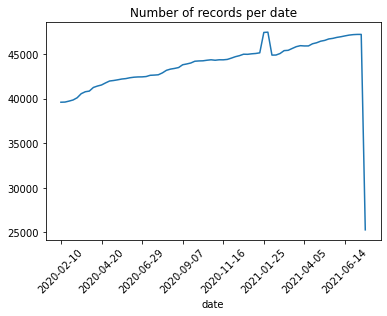

In [33]:
data_cleaned.groupby('date').size().plot()
plt.xticks(rotation=45)
plt.title('Number of records per date')
plt.show()

The peak is flattened but we still have a little one. we will check for duplicates in all the data

In [21]:
data_cleaned[data_cleaned.duplicated(subset=['cell_name','date'],keep=False)]\
            .sort_values(by=['date','cell_name','index'])

,index,cell_name,date,cell_band,cell_tech,cell_sector,year,week,week_period,site_id,total_data_traffic_dl_gb,total_voice_traffic_kerlands,average_throughput_user_dl_kbps,average_throughput_user_ul_kbps,cell_occupation_dl_percentage,average_number_of_users_dl,average_number_of_users_ul,cell_occupation_ul_percentage,total_data_traffic_ul_gb,lost_traffic_kerlands,traffic_loss_rate,average_number_of_users_in_queue
5544,5544,OCI0011_ABOBO_PLAQUE_G18-1,2021-01-25,G18,2G,1,2021,4,202104,OCI0011,4.858,1784.28,39.61,21.35,28.13,NaN,NaN,NaN,0.0,0.000000,NaN,NaN
1188998,11323,OCI0011_ABOBO_PLAQUE_G18-1,2021-01-25,G18,2G,1,2021,4,202104,OCI0011,4.858,1784.28,39.61,21.35,28.13,NaN,NaN,NaN,0.0,0.000000,0.000000,NaN
5569,5569,OCI0011_ABOBO_PLAQUE_G18-2,2021-01-25,G18,2G,2,2021,4,202104,OCI0011,5.847,2992.48,38.78,20.41,31.40,NaN,NaN,NaN,0.0,0.000000,NaN,NaN
1189050,11375,OCI0011_ABOBO_PLAQUE_G18-2,2021-01-25,G18,2G,2,2021,4,202104,OCI0011,5.847,2992.48,38.78,20.41,31.40,NaN,NaN,NaN,0.0,0.000000,0.000000,NaN
5594,5594,OCI0011_ABOBO_PLAQUE_G18-3,2021-01-25,G18,2G,3,2021,4,202104,OCI0011,2.417,1542.22,44.59,23.12,20.72,NaN,NaN,NaN,0.0,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371847,2231523,OCI3242_BENOGOSSO_G18-2,2021-02-01,G18,2G,2,2021,5,202105,OCI3242,6.300,1447.20,30.36,21.12,29.61,NaN,NaN,NaN,0.0,0.000000,NaN,NaN
1173167,1173167,OCI3242_BENOGOSSO_G18-3,2021-02-01,G18,2G,3,2021,5,202105,OCI3242,4.927,523.92,46.09,24.23,15.88,NaN,NaN,NaN,0.0,0.000000,0.000000,NaN
3371857,2231533,OCI3242_BENOGOSSO_G18-3,2021-02-01,G18,2G,3,2021,5,202105,OCI3242,4.927,523.92,46.09,24.23,15.88,NaN,NaN,NaN,0.0,0.000000,NaN,NaN
1175838,1175838,OCI3257_CTCI_G9-1,2021-02-01,G9,2G,1,2021,5,202105,OCI3257,10.230,860.48,47.76,18.79,26.79,NaN,NaN,NaN,0.0,0.090000,0.000105,NaN


We have duplicates in 2G records two. the diffrence between the copies is in lost_traffic_kerlands & traffic_loss_rate. There is no criteria to know which one to keep, so we can't clean data.

## Number of row per sector through time 

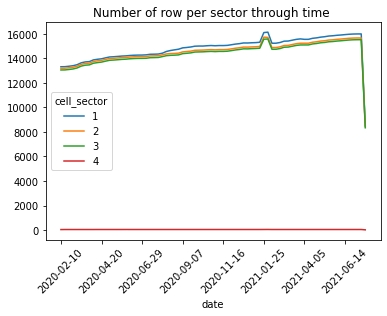

In [34]:
sectors = data_cleaned.groupby(['date','cell_sector']).size().unstack()
sectors.plot()
plt.xticks(rotation=45)
plt.title('Number of row per sector through time ')
plt.show()

There is nothing suspicious in the figure. 
## Number of new/ removed cells per date

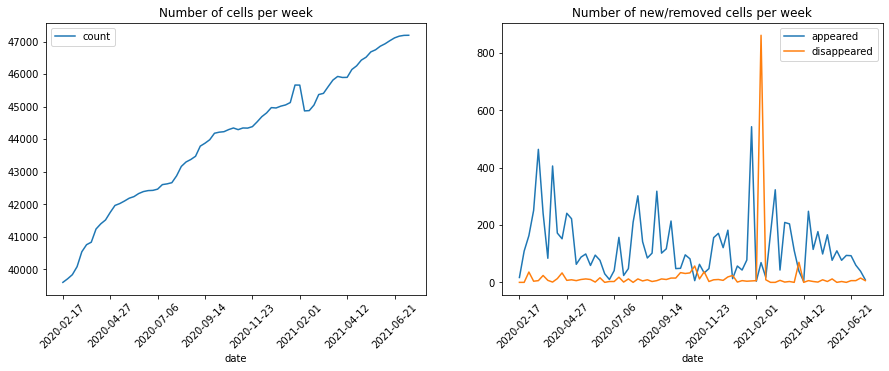

In [15]:
cells_list = data_cleaned.groupby(['date']).cell_name.apply(set)
prev = cells_list[0]
appeared = []
disappeared = []
count=[]
# remove 0 because it does not have a previous and -1 because we do not have enough data
for date,cells in cells_list[1:-1].items():
    appeared += [len(list(cells-prev))]
    disappeared += [len(list(prev-cells))]
    count += [len(cells) ]
    prev = cells
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].set_title('Number of cells per week')
axs[1].set_title('Number of new/removed cells per week')
pd.DataFrame({'count':count},cells_list[1:-1].keys()).plot(ax=axs[0])
pd.DataFrame({'appeared':appeared,'disappeared':disappeared},cells_list[1:-1].keys()).plot(ax=axs[1])
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)

The business team might be intersted in taking a look. The orange peak around 202104 look suspicious. 

## Number of new/ removed sites per date

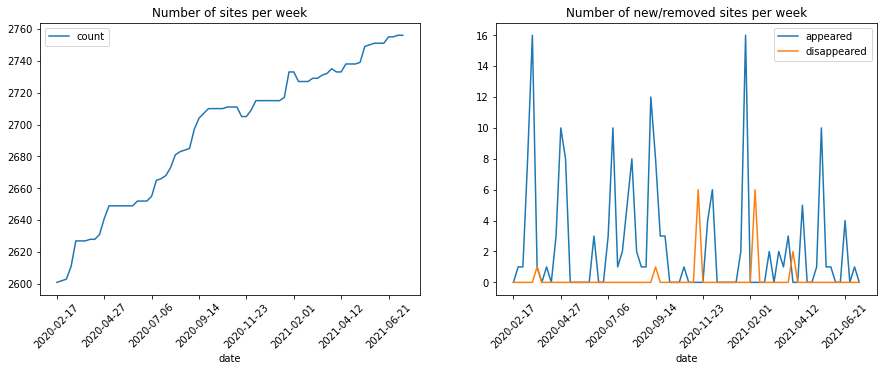

In [13]:
cells_list = data_cleaned.groupby(['date']).site_id.apply(set)
prev = cells_list[0]
appeared = []
disappeared = []
count=[]
# remove 0 because it does not have a previous and -1 because we do not have enough data
for date,cells in cells_list[1:-1].items():
    appeared += [len(list(cells-prev))]
    disappeared += [len(list(prev-cells))]
    count += [len(cells) ]
    prev = cells
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].set_title('Number of sites per week')
axs[1].set_title('Number of new/removed sites per week')
pd.DataFrame({'count':count},cells_list[1:-1].keys()).plot(ax=axs[0])
pd.DataFrame({'appeared':appeared,'disappeared':disappeared},cells_list[1:-1].keys()).plot(ax=axs[1])
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)

The figures seems quite normal.

## Number or records per technology through time

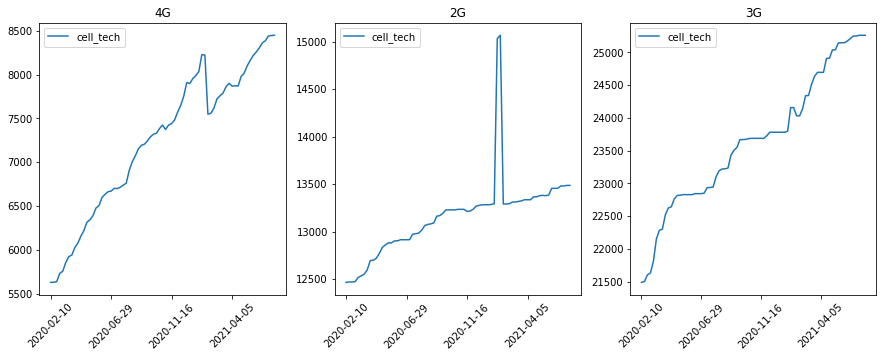

In [12]:
fig, axs = plt.subplots(1,3,figsize=(15,5))
it =0

for tech in data['cell_tech'].unique():
    ax = axs[it]
    ax.set_title(tech)
    df = data_cleaned[data_cleaned['cell_tech'] == tech]
    df.groupby('date').count()[['cell_tech']].plot(ax=ax)
    it+=1
    
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    xaxis = ax.axes.get_xaxis()
    xaxis.set_label_text('')

3G and 4G figures seem normal. The peak in the 2G figure is due to the duplicates situation mentioned earlier
## Number or records per band through time

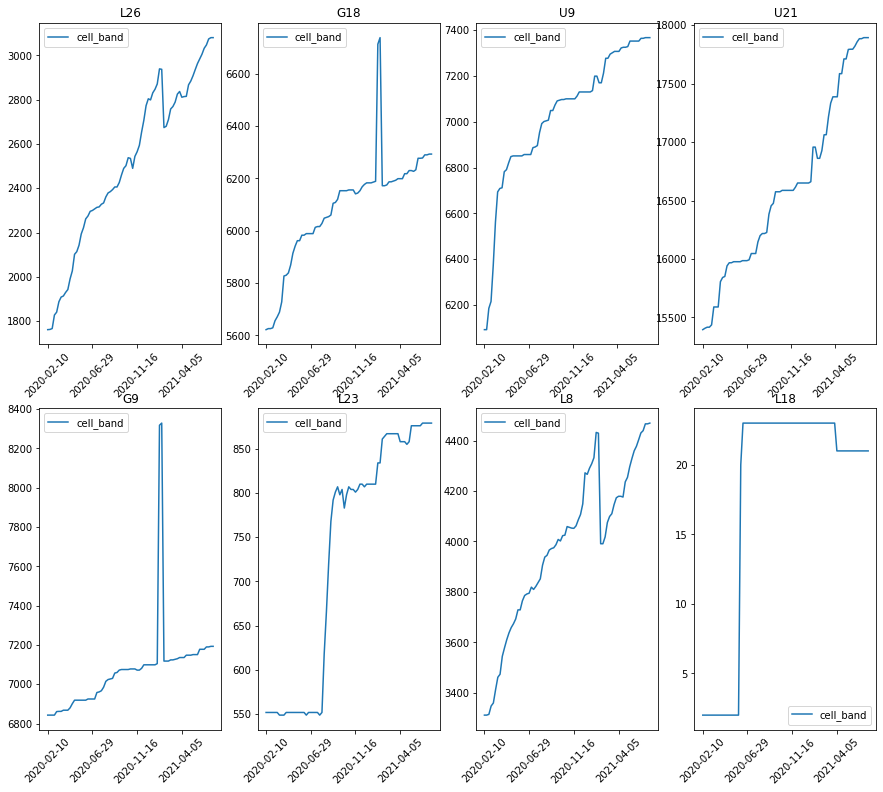

In [25]:
fig, axs = plt.subplots(2,4,figsize=(15,13))
t = [(i,j) for i in range(2) for j in range (4)]
it =0
for band in data_cleaned['cell_band'].unique():
    ax = axs[t[it][0],t[it][1]]
    ax.set_title(band)
    df = data_cleaned[data_cleaned['cell_band'] == band]
    df.groupby('date').count()[['cell_band']].plot(ax=ax)
    it+=1
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    xaxis = ax.axes.get_xaxis()
    xaxis.set_label_text('')